# NFL Big Data Bowl 2022 Notebook
### Author: Conrad Bituin

## Topic to Analyze

Quantify special teams strategy. Special teams’ coaches are among the most creative and innovative in the league. Compare/contrast how each team game plans. Which strategies yield the best results? What are other strategies that could be adopted?


### References
- [Official Competition Page](https://www.kaggle.com/c/nfl-big-data-bowl-2022/overview)
- [Official Explanation of Data](https://www.kaggle.com/c/nfl-big-data-bowl-2022/data)
- [Beginner Notebook via Kaggle](https://www.kaggle.com/werooring/nfl-big-data-bowl-basic-eda-for-beginner/notebook)
- [Previous Bowl Recaps](https://operations.nfl.com/gameday/analytics/big-data-bowl/past-big-data-bowl-recaps/)

## Background

As of the writing of this notebook (Week 14, 2021 Season), NFL kickers have collectively missed 69 extra point attempts (PATs) and 122 field goals in the 2021 season [according to Pro Football Reference](https://www.pro-football-reference.com/). The intent of this notebook is to analyze the various situations and scenarios that could affect PAT and field goal outcomes. The model produced will attempt to find the optimal field conditions that will produce the highest likelihood for successful extra point and field goal attempts.

## Acquire Data

In [1]:
# Common imports

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import numpy as np
import pandas as pd

In [2]:
# File imports

# The games.csv contains the teams playing in each game. The key variable is gameId.
games_df = pd.read_csv('../data/games.csv')

# The PFFScoutingData.csv file contains play-level scouting information for each game. The key variables are gameId and playId.
pffscouting_df = pd.read_csv('../data/PFFScoutingData.csv')

# The players.csv file contains player-level information from players that participated in any of the tracking data files. The key variable is nflId.
players_df = pd.read_csv('../data/players.csv')

# The plays.csv file contains play-level information from each game. The key variables are gameId and playId.
plays_df = pd.read_csv('../data/plays.csv')

#Files tracking[season].csv contain player tracking data from season [season]. The key variables are gameId, playId, and nflId.
tracking_2018_df = pd.read_csv('../data/tracking2018.csv')
tracking_2019_df = pd.read_csv('../data/tracking2019.csv')
tracking_2020_df = pd.read_csv('../data/tracking2020.csv')

## Analyze and Describe Data

### Summary 

Based on the data provided for consideration, there are a total of:
- 764 games
- 2732 players
- 4435 plays
  - 1986 plays were Field Goal attempts
  - 2345 plays were Extra Point attempts 


### Overview of Games, Plays, and Players

In [3]:
print('Dataframe: Games')
games_df.head()

Dataframe: Games


,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr
0,2018090600,2018,1,09/06/2018,20:20:00,PHI,ATL
1,2018090900,2018,1,09/09/2018,13:00:00,BAL,BUF
2,2018090901,2018,1,09/09/2018,13:00:00,CLE,PIT
3,2018090902,2018,1,09/09/2018,13:00:00,IND,CIN
4,2018090903,2018,1,09/09/2018,13:00:00,MIA,TEN


In [4]:
print('Dataframe: Players')
players_df.head()

Dataframe: Players


,nflId,height,weight,birthDate,collegeName,Position,displayName
0,42901,6-1,208,1992-07-25,James Madison,SS,Dean Marlowe
1,43501,6-0,220,1994-08-11,Central Michigan,FS,Kavon Frazier
2,43534,6-0,205,1993-06-02,Illinois,SS,Clayton Fejedelem
3,43535,6-1,235,1992-12-22,Temple,MLB,Tyler Matakevich
4,44174,6-1,236,1993-02-22,Texas Tech,ILB,Sam Eguavoen


In [5]:
print('Dataframe: Plays')
plays_df.head()

Dataframe: Plays


,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,penaltyCodes,penaltyJerseyNumbers,penaltyYards,preSnapHomeScore,preSnapVisitorScore,passResult,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber
0,2018090600,37,J.Elliott kicks 65 yards from PHI 35 to end zo...,1,0,0,PHI,Kickoff,Touchback,44966.0,...,NaN,NaN,NaN,0,0,NaN,66.0,NaN,40,45
1,2018090600,366,"(9:20) C.Johnston punts 56 yards to ATL 36, Ce...",1,4,4,PHI,Punt,Return,45603.0,...,UNSd,PHI 18,-15.0,0,0,NaN,56.0,5.0,36,18
2,2018090600,658,"(5:03) M.Bryant 21 yard field goal is GOOD, Ce...",1,4,3,ATL,Field Goal,Kick Attempt Good,27091.0,...,NaN,NaN,NaN,0,0,NaN,21.0,NaN,0,13
3,2018090600,677,M.Bosher kicks 64 yards from ATL 35 to PHI 1. ...,1,0,0,ATL,Kickoff,Return,37267.0,...,NaN,NaN,NaN,0,3,NaN,64.0,30.0,34,75
4,2018090600,872,"(:33) C.Johnston punts 65 yards to end zone, C...",1,4,18,PHI,Punt,Touchback,45603.0,...,NaN,NaN,NaN,0,3,NaN,65.0,NaN,45,45


#### Visualization of Field Goal and Extra Point Attempts

In [61]:
# Preparing Data for Visualization
%matplotlib inline

fg_df = plays_df[plays_df.specialTeamsPlayType == 'Field Goal']
pat_df = plays_df[plays_df.specialTeamsPlayType == 'Extra Point']

fg_df_by_quarter = fg_df.groupby('quarter').nunique().reset_index()[['quarter','playId']]
fg_df_by_down = fg_df.groupby('down').nunique().reset_index()[['down','playId']]
fg_success_by_kicker = fg_df[fg_df.specialTeamsResult == 'Kick Attempt Good'].groupby('kickerId').nunique().reset_index()[['kickerId','playId']]

fg_success_by_kicker

,kickerId,playId
0,21213.0,38
1,23860.0,5
2,25326.0,19
3,27091.0,28
4,29874.0,17
5,30403.0,66
6,30932.0,51
7,31446.0,65
8,32371.0,38
9,32386.0,62


In [18]:
fg_df.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,penaltyCodes,penaltyJerseyNumbers,penaltyYards,preSnapHomeScore,preSnapVisitorScore,passResult,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber
2,2018090600,658,"(5:03) M.Bryant 21 yard field goal is GOOD, Ce...",1,4,3,ATL,Field Goal,Kick Attempt Good,27091.0,...,NaN,NaN,NaN,0,0,NaN,21.0,NaN,0,13
6,2018090600,1368,"(6:12) J.Elliott 26 yard field goal is GOOD, C...",2,4,8,PHI,Field Goal,Kick Attempt Good,44966.0,...,NaN,NaN,NaN,0,3,NaN,26.0,NaN,0,18
8,2018090600,1587,"(2:13) M.Bryant 52 yard field goal is GOOD, Ce...",2,4,17,ATL,Field Goal,Kick Attempt Good,27091.0,...,NaN,NaN,NaN,3,3,NaN,52.0,NaN,0,76
33,2018090900,1226,(13:18) (Field Goal formation) J.Tucker 41 yar...,2,4,13,BAL,Field Goal,Kick Attempt Good,39470.0,...,NaN,NaN,NaN,14,0,NaN,41.0,NaN,0,33
36,2018090900,1613,(8:48) (Field Goal formation) S.Hauschka 52 ya...,2,4,9,BUF,Field Goal,Kick Attempt No Good,33469.0,...,NaN,NaN,NaN,17,0,NaN,52.0,NaN,-8,76


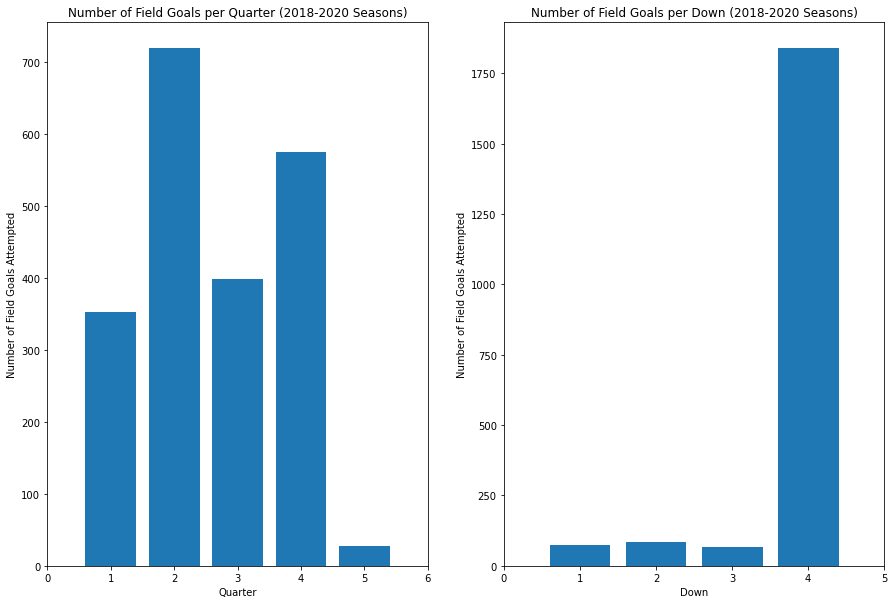

In [55]:
plt.figure(figsize=(15,10))

# Field Goals per Quarter
plt.subplot(1,2,1)
plt.bar(fg_df_by_quarter.quarter, fg_df_by_quarter.playId)
plt.title('Number of Field Goals per Quarter (2018-2020 Seasons)')
plt.xlabel('Quarter')
plt.ylabel('Number of Field Goals Attempted')
plt.xlim(0, 6)


# Field Goals per Down
plt.subplot(1,2,2)
plt.bar(fg_df_by_down.down, fg_df_by_down.playId)
plt.title('Number of Field Goals per Down (2018-2020 Seasons)')
plt.xlabel('Down')
plt.ylabel('Number of Field Goals Attempted')
plt.xlim(0, 5)
plt.show()

### Overview of Tracking Data for NFL Seasons 2018-2020

In [ ]:
print('Dataframe: 2018 Season')
tracking_2018_df.head()

In [ ]:
print('Dataframe: 2019 Season')
tracking_2019_df.head()

In [ ]:
print('Dataframe: 2020 Season')
tracking_2020_df.head()

## Wrangle Data

### Feature Engineering

In [ ]:
fg_df = plays_df[plays_df.specialTeamsPlayType == 'Field Goal']
pat_df = plays_df[plays_df.specialTeamsPlayType == 'Extra Point']


### Response Engineering